# GNN with PyG 
#### Generic GNN model for any WDS
-Custom layer for Graph Neural Networks using PyTorch Geometric

## Imports

### Basic

In [1]:
import wntr
import pandas as pd
import numpy as np
import networkx as nx
import pickle
import time
import winsound

### PyTorch

In [2]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import Tensor
#from torch.nn import Sequential, Linear, ReLU

In [3]:
print(torch.__version__) #Hopefully 1.7.1

1.7.1


### PyTorch Geometric

In [4]:
#message passing
from torch_geometric.nn import MessagePassing, EdgeConv
from torch_geometric.nn import GCNConv, NNConv

import torch_geometric

from torch_geometric.data import Data


from torch_geometric.utils import convert, get_laplacian, to_dense_adj #, add_self_loops, degree,

from torch_geometric.typing import Adj#, Union#, Size, OptTensor

from torch_sparse import matmul, SparseTensor

from torch_geometric.nn import global_mean_pool




C:\Programs\Anaconda3\envs\PyTorch_Env\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


### RunBuilder and RunManager

In [5]:
from collections import OrderedDict
from collections import namedtuple
from itertools import product

from torch.utils.data import DataLoader
#from torch.utils.tensorboard import SummaryWriter

### Scikit-Learn

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

### Performance

In [7]:
# from joblib import Parallel, delayed

### Visualization

In [8]:
import ipywidgets as widgets
from IPython.display import clear_output, display
import plotly.graph_objects as go

### Custom

In [9]:
from wntr_to_nx import from_wntr_to_nx
from Models.G_filter_K import G_filter_K

## Utilities

### Scaler

In [10]:
class Scaler():
    def __init__(self, type_norm, par1=None, par2=None):
        self.par1 = par1
        self.par2 = par2
        assert type_norm in ['Linear', 'Gaussian'], 'Linear or Gaussian?'
        self.type_norm = type_norm
        
        
    def scale(self, list_of_values):
        
        if self.type_norm == 'Linear':
            if self.par1 is None:
                minT = min(list_of_values)
                self.par1 = minT
            else:
                minT= self.par1
            
            if self.par2 is None:
                maxT = max(list_of_values)
                self.par2 = maxT
            else:
                maxT= self.par2    
            assert maxT-minT != 0, 'Max and min values are equal'
            normalized_data = (list_of_values - minT)/(maxT - minT)
        else:
            if self.par1 ==None and self.par2 ==None:
                means = list_of_values.mean()#dim=0, keepdim=True)
                self.par1 = means
                stds = list_of_values.std()#dim=0, keepdim=True)
                self.par2 = stds
            else:
                means = self.par1
                stds = self.par2
            assert stds != 0, 'Standard deviation is zero'
            normalized_data = (list_of_values - means) / stds
        
        return normalized_data


    def rescale(self, scaledList):
        if self.type_norm == 'Linear':
            ans = (scaledList)*(self.par2 - self.par1) + self.par1
        else:
            ans = scaledList*self.par2 + self.par1
        return ans

### RunBuilder

In [11]:
class RunBuilder():
    @staticmethod
    def get_runs(params):

        Run = namedtuple('Run', params.keys())

        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs

### Loading bar

In [12]:
f = widgets.IntProgress(
    value=7,
    min=0,
    max=10,
    step=1,
    description='Loading:',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    orientation='horizontal'
)

### Graph R2

*Further improvements required

In [13]:
def graph_r2(model,graphs):
#     preds =[]
#     y = []
#     for g in graphs:
#         preds.append(model(g).detach().numpy())
#         y.append(g.y.detach().numpy())
    #print(preds, y)
    preds = model(graphs)
    y = graphs.y
    #print(preds, y)
    
    r_squared = r2_score( np.array(y).flatten() , np.array(preds.detach()).flatten() )
    return(r_squared)

### Model Preds and Targets

In [159]:
# def res_and_tar(model,graphs):
#     preds =[]
#     y = []
#     for g in graphs:
#         preds.append(model(g).mean().detach().numpy())
#         y.append(g.y.detach().numpy())
#     #print(preds, y)
#     #r_squared = r2_score( np.array(y).flatten() , np.array(preds).flatten() )
#     return(np.array(preds).flatten(), np.array(y).flatten())

### Graph -results

In [15]:
def pred_vs_y_plotly(x_real_values_train, y_pred_values_train, x_real_values_test, y_pred_values_test):
    fig = go.FigureWidget(data=go.Scatter(x=x_real_values_train, y=y_pred_values_train,  line={'dash': 'dash'}, name = 'Train'))

    fig.add_trace(go.Scatter(x=x_real_values_test, y=y_pred_values_test,  line={'dash': 'dash'}, name='Test'))
    #fig.add_trace(go.Scatter(x=x_axis, y=first_DB_pd['minPrPa'],  line={'dash': 'dash'}, name='Min. Res.'))


    fig.update_traces(mode='markers',  marker_size=3)
    fig.update_layout(title='Pred. vs Actual - Prasad & Park Resilience Index',
                        xaxis_title="Real Index",
                        yaxis_title="Pred. Index",
                        legend_title="Legend",
                        legend= {'itemsizing': 'constant'},
                        autosize=False,
                        width=800,
                        height=500,
                        font=dict(
                            #family="Courier New, monospace",
                            size=18,
        ))
    #yaxis_zeroline=False, xaxis_zeroline=False)
    fig.update_layout(shapes=[
    dict(
      type= 'line',
      yref= 'y', y0= -0.30, y1= 1,   # adding a horizontal line at Y = 1
      xref= 'x', x0= -0.30, x1= 1
         ) 
    ])

    fig.update_xaxes(range=[-0.3, 1])
    fig.update_yaxes(range=[-0.3, 1])
    
    return fig

## Dataset 

### Loading inp and database

In [16]:
!cd 

C:\Users\agarzondiaz\surfdrive\Year 1\AnyTown Database\AnyTown_DB\GNN code


(<matplotlib.collections.PathCollection at 0x1c721a62ac0>,
 <matplotlib.collections.LineCollection at 0x1c721a3be80>)

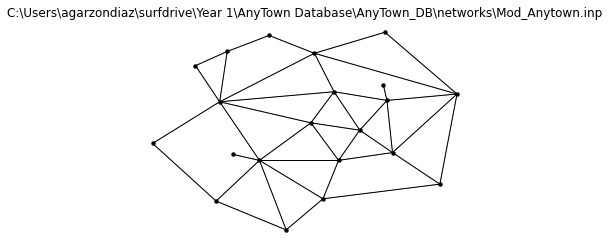

In [17]:
# Create a water network model
#inp_file = 'Exeter/BLA.inp'
inp_file =r'C:\Users\agarzondiaz\surfdrive\Year 1\AnyTown Database\AnyTown_DB\networks\Mod_Anytown.inp' 
wn_WDS = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn_WDS, title=wn_WDS.name)

# Simulate hydraulics
# sim_WDS = wntr.sim.EpanetSimulator(wn_WDS)
# results_WDS = sim_WDS.run_sim()

In [18]:
#del database

In [20]:
# Import database: contains information for all the simulations run
try:
    print(database is None)
except:
    #database = pickle.load( open( "Datasets/BLA_dataset.p", "rb" ))
    database = pickle.load( open( r"C:\Users\agarzondiaz\surfdrive\Year 1\AnyTown Database\AnyTown_DB\Mod_Anytown_Geom_DB_5000\Mod_Anytown_dataset.p", "rb" ))

False


In [21]:
database = database['data']

In [22]:
database[0]

Data(ID=[21], base_demand=[21], base_head=[21], demand=[21], diameter=[80], edge_index=[2, 80], elevation=[21], length=[80], pos=[21, 2], pressure=[21], res_PP=0.11929542571306229, res_Todini=0.29142066836357117, roughness=[80], type=[80], type_1H=[21])

### Geometric Dataset

Organize and normalize the dataset 

In [23]:
torch.set_default_dtype(torch.float64)

#### Scalers

In [24]:
elev_and_head = torch.cat((database[0].elevation, database[0].base_head))

In [25]:
sc_base_dem  = Scaler(type_norm='Gaussian')
sc_head_elev = Scaler(type_norm='Linear', par1 = min(elev_and_head), par2 =max(elev_and_head) )

sc_diameter  = Scaler(type_norm='Linear', par1 = 0, par2 = 1)
sc_length    = Scaler(type_norm='Gaussian')
sc_roughness = Scaler(type_norm='Linear', par1=80, par2=150)


#### Creating the final graphs
These graphs contain the information in the nodes (x), edges (edge_attr), and the target (res_PP)

In [221]:
graphs = []
for i in database:
    if i.res_PP>0:
        current = Data()
        current.edge_index = i.edge_index
        current.ID =  i.ID
        current.pos = i.pos

        current.x = torch.cat(( i.type_1H.view(-1,1),      #Already normalized
                                sc_base_dem.scale(i.base_demand).view(-1,1),  #
                                sc_head_elev.scale(i.base_head).view(-1,1),
                                sc_head_elev.scale(i.elevation).view(-1,1)), 1).double()

        current.edge_attr = torch.cat(( 
                            sc_diameter.scale(i.diameter).view(-1,1),
                            sc_length.scale(i.length).view(-1,1), 
                            sc_roughness.scale(i.roughness).view(-1,1))
                            , 1).double()

        current.y = sc_head_elev.scale(i.pressure)#i.res_Todini##
        
        current.demand_WNTR = i.demand
        current.todini = i.res_Todini

        graphs.append(current)
    

In [222]:
#Example of the normalized weights in the adjacency matrix (as edge index and edge weight)
#graphs[3].weight.t(), graphs[3].edge_index
#graphs[3].diams_n.t(), graphs[3].edge_index

In [223]:
#graphs[3].base_head

In [224]:
len(graphs)

4788

In [215]:
graphs[3].demand_WNTR

tensor([ 0.0315,  0.0126,  0.0126,  0.0126,  0.0000,  0.0315,  0.0315,  0.0000,
         0.0315,  0.0631,  0.0315,  0.0315,  0.0000,  0.0126,  0.0126,  0.0126,
         0.0126,  0.0505,  0.0126, -0.1564, -0.2473], dtype=torch.float32)

### Data split

In [216]:
# create dataset
#split_ix = 3000
seed = 1135
batch_size = 32
split_ix = int(0.8 * len(graphs))
#val_size = int(0.2 * len(graphs))
train_loader = torch_geometric.data.DataLoader(graphs[:split_ix], batch_size=batch_size, shuffle=True)
valid_loader = torch_geometric.data.DataLoader(graphs[split_ix:], batch_size=batch_size, shuffle=True)

In [217]:
# for step, data in enumerate(train_loader):
#     print(f'Step {step + 1}:')
#     print('=======')
#     print(f'Number of graphs in the current batch: {data.num_graphs}')
#     print(data)
#     print()

In [218]:
#seed = 1135
#train_size = int(0.8 * len(graphs))
#val_size = int(0.1 * len(graphs))
#test_size = len(graphs) -val_size - train_size
#train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(graphs, [train_size, val_size, test_size],generator=torch.Generator().manual_seed(seed))

## **Message Passing**

**MessagePassing(aggr="add", flow="source_to_target", node_dim=-2):** \
Defines the aggregation scheme to use ("add", "mean" or "max") and the flow direction of message passing (either "source_to_target" or "target_to_source"). Furthermore, the node_dim attribute indicates along which axis to propagate.

$${\huge \mathbf{x}_i^{\prime} = \gamma_{\mathbf{\Theta}} \left( \mathbf{x}_i,
\square_{j \in \mathcal{N}(i)} \, \phi_{\mathbf{\Theta}}
\left(\mathbf{x}_i, \mathbf{x}_j,\mathbf{e}_{j,i}\right) \right) }$$ 

where $\square$ denotes a differentiable, permutation invariant function, e.g., sum, mean or max, and $\gamma_{\mathbf{\Theta}}$ and $ \phi_{\mathbf{\Theta}}$ denote differentiable functions such as MLPs.
Source: [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html)

### Layer definition

#### Graph filter

### Model definition

In [219]:
next(iter(train_loader))

Batch(ID=[32], batch=[672], demand_WNTR=[672], edge_attr=[2560, 3], edge_index=[2, 2560], pos=[672, 2], todini=[32], x=[672, 4], y=[32])

In [220]:
a = G_filter_K(units = [1, 32], aggr ='add', K = 2)

In [39]:
for i in a.parameters():
    print(i.shape)

torch.Size([1, 32])
torch.Size([1, 32])
torch.Size([1, 32])


In [41]:
#graphs[0].x[:,1:4].view(-1, 3)

In [225]:
class Net(nn.Module):
    def __init__(self, hid_units, K):
        super(Net, self).__init__()
        self.K = K
        self.hid_units = hid_units
        self.conv1 = G_filter_K(units = [3, self.hid_units], aggr ='add', K = self.K)
        self.conv2 = G_filter_K(units = [self.hid_units, self.hid_units], aggr ='add', K = self.K)
        self.conv3 = G_filter_K(units = [self.hid_units, 1], aggr ='add', K = self.K)
#         self.conv4 = G_filter_K(units = [self.hid_units, 1], aggr ='add', K = self.K)
#         self.fc1 = nn.Linear(self.hid_units,1)
#         self.fc2 = nn.Linear(int(self.hid_units/2),1)

    def forward(self, data, prt=False):
        edge_attr  = data.edge_attr[:,0].view(-1,)
        edge_index = data.edge_index
        #print(data)
        
        try:
            batch = data.batch
        except:
            batch = torch.zeros(len(data.x), dtype = torch.int64)
        
        x = data.x[:,1:4].view(-1, 3)#torch.ones((len(batch),1))
        
        
        
        x = self.conv1(x, edge_attr, edge_index)
        x = torch.sigmoid(x)

        x = self.conv2(x, edge_attr, edge_index)
        x = torch.sigmoid(x)
        
        x = self.conv3(x, edge_attr, edge_index)
        x = torch.sigmoid(x)
        
#         x = self.conv4(x, edge_attr, edge_index)
#         x = torch.sigmoid(x)
        
#         x = self.fc1(x)
#         x = torch.sigmoid(x)
        
#         if prt == True:
#             print(x)
        
#         x = self.fc1(x)
#         x = torch.sigmoid(x)
        
#         x = global_mean_pool(x, batch)
        
        
        return x  #, x
    
    # Calculates the number of parameters for each layer (weights and biases are summed together)
    def N_parameters(self):
        self.num_params = []
#         i = 0
        
        for parameter in self.parameters():
            self.num_params.append(torch.numel(parameter))

        return self.num_params

In [226]:
#model = Net(hid_units = 32, K=2)#.to(device)

In [227]:
#sum(model.N_parameters())

## Training

### Hyperparameters

In [228]:
#N_epochs = 1000
params = OrderedDict(
    lr = [2e-4]
    ,weight_decay=[0]
    ,N_epochs = [100]
    ,hid_units = [32]
    ,K = [2]
    #,batch_size = [50] #T.B.I
)

report_freq=5

In [124]:
runs = RunBuilder.get_runs(params)

In [125]:
runs

[Run(lr=0.0002, weight_decay=0, N_epochs=100, hid_units=32, K=2)]

### Forward and Backpropagation

#### Batch training

In [126]:
#len(model(next(iter(train_loader))))

In [127]:
next(iter(train_loader))

Batch(ID=[32], batch=[672], demand_WNTR=[672], edge_attr=[2560, 3], edge_index=[2, 2560], pos=[672, 2], todini=[32], x=[672, 4], y=[672])

In [128]:
f.description = 'Loading...'
display(f)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for run in RunBuilder.get_runs(params):
    print("-------------------New configuration-------------------")
    model = Net(hid_units = run.hid_units, K=run.K).to(device)
    start_time = time.time()
    optimizer = torch.optim.Adam(model.parameters(), lr=run.lr, weight_decay=run.weight_decay)
    f.value = 0
    f.max = run.N_epochs
    model.train()
    for epoch in range(run.N_epochs):
        total_loss= 0
        
        for training_graph in train_loader:
            pred = model(training_graph)#[0]
            target = training_graph.y
            loss = F.mse_loss(pred.to(torch.float32).view(-1,1), target.to(torch.float32).view(-1,1))
            
            #print(pred, target)
            loss.to(torch.float64)
            total_loss += loss
        
            #total_loss /= len(train_dataset)
            #total_loss = total_loss.to(torch.float32)
            optimizer.zero_grad()
            #print(loss.dtype)
            loss.backward()
            optimizer.step()
        
        f.value += 1
        f.description = 'Epoch {}/{}'.format(epoch+1,f.max)
        if epoch%report_freq == 0 or epoch == run.N_epochs-1:
            #print(model.conv1.H[0])
            r2 = np.round(graph_r2(model, training_graph), 4)
            print('\t', "epoch ", epoch, '\t'," total loss:  ", np.round(total_loss.item(),4), '\t', 'R2: ', r2)
            
    comment = f'-{run}'
    execution_time=np.round((time.time() - start_time), 2)
    print(comment, execution_time, 'seconds')
    print('Total parameters:','\t', np.array(model.N_parameters()).sum(), "\n")
    
winsound.Beep(1000, 100) #Ending sound


IntProgress(value=100, description='Loading...')

-------------------New configuration-------------------


C:\Programs\Anaconda3\envs\PyTorch_Env\lib\site-packages\torch\nn\modules\container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


	 epoch  0 	  total loss:   10.2254 	 R2:  0.0308
	 epoch  5 	  total loss:   0.919 	 R2:  0.8824
	 epoch  10 	  total loss:   0.5832 	 R2:  0.918
	 epoch  15 	  total loss:   0.4553 	 R2:  0.937
	 epoch  20 	  total loss:   0.3801 	 R2:  0.9607
	 epoch  25 	  total loss:   0.3284 	 R2:  0.9567
	 epoch  30 	  total loss:   0.2967 	 R2:  0.972
	 epoch  35 	  total loss:   0.2739 	 R2:  0.9491
	 epoch  40 	  total loss:   0.2584 	 R2:  0.9573
	 epoch  45 	  total loss:   0.2447 	 R2:  0.9489
	 epoch  50 	  total loss:   0.2351 	 R2:  0.9788
	 epoch  55 	  total loss:   0.228 	 R2:  0.96
	 epoch  60 	  total loss:   0.2202 	 R2:  0.9722
	 epoch  65 	  total loss:   0.2161 	 R2:  0.9556
	 epoch  70 	  total loss:   0.2107 	 R2:  0.9617
	 epoch  75 	  total loss:   0.2051 	 R2:  0.9841
	 epoch  80 	  total loss:   0.2025 	 R2:  0.9749
	 epoch  85 	  total loss:   0.1991 	 R2:  0.9735
	 epoch  90 	  total loss:   0.1975 	 R2:  0.9865
	 epoch  95 	  total loss:   0.1941 	 R2:  0.9646
	 epoch 

In [130]:
r2 = np.round(graph_r2(model, next(iter(valid_loader))), 4)

In [131]:
r2

0.9748

In [132]:
start = time.time()
model(graphs[0], prt = True) #, graphs[0].y
end = time.time()
print(end - start)


0.001967191696166992


In [133]:
sc_head_elev.rescale(graphs[1].y)

tensor([50.8208, 43.3675, 43.3036, 43.3191, 34.1748, 46.4716, 42.4384, 34.1741,
        43.4126, 43.7368, 42.9996, 42.9155, 34.1739, 21.8630, 21.8604, 34.1733,
        21.9831, 21.9237, 21.4791,  0.0000,  0.0000], dtype=torch.float32)

In [134]:
print(sc_head_elev.rescale(model(graphs[1]).view(-1)))

tensor([53.4819, 46.9599, 47.5880, 45.3183, 38.7276, 46.6710, 45.5058, 37.0097,
        44.6706, 45.9184, 45.1836, 44.0704, 35.3591, 21.9074, 22.1980, 33.4664,
        20.8527, 22.7775, 25.6725,  0.5474,  0.3957], grad_fn=<AddBackward0>)


In [135]:
#a, b = model(graphs[-1]), model(graphs[-1]).detach().numpy()

In [136]:
graphs[0].x[:,2]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1.])

In [137]:
node_names = wn_WDS.node_name_list
a = pd.DataFrame(sc_head_elev.rescale(model(graphs[0])).detach().view(1, -1).numpy(), columns = node_names)

In [94]:
sim_WDS = wntr.sim.EpanetSimulator(wn_WDS)
results_WDS = sim_WDS.run_sim()
#results_WDS.node['pressure'].iloc[0]

In [79]:
#demand

In [80]:
# a = iter(wn_WDS.junctions())
# for i in range(6):
#     print(next(a))

In [81]:
# np.array(results_WDS.node['demand'].loc[64800].values)#.reshape(1,-1)

In [139]:
# pd.DataFrame(np.array(results_WDS.node['demand'].loc[64800].values).reshape(1,-1), columns = node_names)

In [140]:
#head #= pd.DataFrame(sc_head_elev.rescale(graphs[69].x[:,3]).view(1, -1).numpy(), columns = node_names) #Pandas dataframe
#elevation_res #= pd.DataFrame(sc_head_elev.rescale(graphs[69].x[:,2]).view(1, -1).numpy(), columns = node_names) #Pandas dataframe

In [141]:
pd.DataFrame(np.array(graphs[node].demand_WNTR).reshape(1,-1), columns = node_names)

20        30        40        50   55        60        70   75  \
0  0.031545  0.012618  0.012618  0.012618  0.0  0.031545  0.031545  0.0   

         80       90  ...       110  115       120       130       140  \
0  0.031545  0.06309  ...  0.031545  0.0  0.012618  0.012618  0.012618   

        150       160       170        65     165  
0  0.012618  0.050472  0.012618 -0.183177 -0.2206  

[1 rows x 21 columns]

In [142]:
#wn_WDS = wntr.network.WaterNetworkModel(inp_file_path)
node_names = wn_WDS.node_name_list
node = 10

pressure = pd.DataFrame(sc_head_elev.rescale(model(graphs[node])).detach().view(1, -1).numpy(), columns = node_names) #Pandas dataframe

head = pd.DataFrame(sc_head_elev.rescale(graphs[node].x[:,3]).view(1, -1).numpy(), columns = node_names) #Pandas dataframe
elevation_res = pd.DataFrame(sc_head_elev.rescale(graphs[node].x[:,2]).view(1, -1).numpy(), columns = node_names) #Pandas dataframe

total_head = pressure + head + elevation_res
#demand = pd.DataFrame(sc_base_dem.rescale(graphs[69].x[:,1]).view(1, -1).numpy(), columns = node_names) #Pandas dataframe

#Cheating with the model results for the demand part
demand = pd.DataFrame(np.array(graphs[node].demand_WNTR).reshape(1,-1), columns = node_names)#pd.DataFrame(results_WDS.node['demand'].loc[64800])
flowrate = 0

RI_Todini = wntr.metrics.hydraulic.todini_index(total_head, pressure, demand, flowrate, wn_WDS, 28.1236)

In [143]:
RI_Todini #Estimated

0    0.728613
dtype: float64

In [109]:
sc_head_elev.rescale(model(graphs[node])).t()

tensor([[53.6976, 47.9431, 42.3707, 45.7074, 37.7406, 46.7302, 50.1849, 37.4116,
         45.8064, 46.1182, 45.2679, 46.7085, 36.1310, 22.3940, 25.4305, 39.6094,
         25.9307, 25.2306, 26.2025,  2.8540,  1.8818]], grad_fn=<TBackward>)

In [110]:
sc_head_elev.rescale(graphs[node].y)

tensor([56.4552, 48.3511, 48.1060, 47.9000, 38.7562, 48.7242, 47.6290, 38.7565,
        47.8919, 47.6277, 47.8298, 47.9866, 38.7565, 26.7060, 26.7047, 38.7565,
        26.5645, 26.7438, 26.1092,  0.0000,  0.0000], dtype=torch.float32)

In [144]:
graphs[node].todini

tensor(0.8610)

In [147]:
RI_Todini = wntr.metrics.hydraulic.todini_index(results_WDS.node['head'], results_WDS.node['pressure'], results_WDS.node['demand'], flowrate, wn_WDS, 28.1236)

In [148]:
RI_Todini[64800]

0.923596203327179

In [450]:
#results_WDS.node['demand'].loc[64800]

In [149]:
#demand

In [150]:
#print(RI_Todini, graphs[69].todini)

In [152]:
#database[0].pressure

#### Joblib implementation - Update: Failed, it's slower

In [207]:
# def fun(training_graph):
#     pred = model(training_graph).mean()
#     target = training_graph.y
#     loss = F.mse_loss(pred.reshape(-1,1), target.reshape(-1,1))            
#     #loss.to(torch.float32)
    
#     return loss

In [220]:
# for run in RunBuilder.get_runs(params):
#     display(f)
#     start_time = time.time()
#     optimizer = torch.optim.Adam(model.parameters(), lr=run.lr, weight_decay=run.weight_decay)
#     f.value = 0
#     f.max = run.N_epochs
#     model.train()
#     for epoch in range(run.N_epochs):
#         total_loss= 0
#         losses = Parallel(n_jobs=-1)(delayed(fun)(training_graph) for training_graph in train_dataset)
#         total_loss = torch.tensor(losses, requires_grad=True).mean()
#         #total_loss.requires_grad = True
#         #print(total_loss)
#         #total_loss /= len(train_dataset)
#         #total_loss = total_loss.to(torch.float32)
#         optimizer.zero_grad()
#         total_loss.backward()
#         optimizer.step()
        
#         f.value += 1
#         if epoch%10 == 0:
#             print("epoch ", epoch, " total loss  ", total_loss )
# #             clear_output(wait=True)
# #             display(f)
            
#     comment = f'-{run}'
#     execution_time=np.round((time.time() - start_time),2)
#     print(comment, execution_time, 'seconds')

IntProgress(value=51, description='Loading:', max=51)

epoch  0  total loss   tensor(0.1603, grad_fn=<MeanBackward0>)
epoch  10  total loss   tensor(0.1563, grad_fn=<MeanBackward0>)
epoch  20  total loss   tensor(0.1522, grad_fn=<MeanBackward0>)
epoch  30  total loss   tensor(0.1482, grad_fn=<MeanBackward0>)
epoch  40  total loss   tensor(0.1443, grad_fn=<MeanBackward0>)
epoch  50  total loss   tensor(0.1404, grad_fn=<MeanBackward0>)
-Run(lr=0.001, weight_decay=0.0005, N_epochs=51) 206.75 seconds


## Testing
*To be further implemented

In [157]:
training = torch_geometric.data.DataLoader(train_loader.dataset, batch_size= len(train_loader.dataset))
validation = torch_geometric.data.DataLoader(valid_loader.dataset, batch_size= len(valid_loader.dataset))
print('Training R2: \t', np.round(graph_r2(model, next(iter(training))), 4))
print('Validation R2: \t', np.round(graph_r2(model, next(iter(validation))), 4))

Training R2: 	 0.9694
Validation R2: 	 0.97


In [166]:
#list(iter(validation))
a=model(next(iter(validation)))

In [167]:
len(a)

20118

In [190]:
#Simple test
# print('Actual \t',  'Pred')
# for i in range(10):
#     print(np.round(rescale(graphs[i].y.item(),-1,1),4), '\t', np.round(rescale(model(graphs[i]).item(), -1,1),4) )

def results_todini(dataset):
    preds = []
    actual = []
    for grp in dataset:

    #     node_names = wn_WDS.node_name_list
    #     node = 10

        pressure = pd.DataFrame(sc_head_elev.rescale(model(grp)).detach().view(1, -1).numpy(), columns = node_names) #Pandas dataframe

        head = pd.DataFrame(sc_head_elev.rescale(grp.x[:,3]).view(1, -1).numpy(), columns = node_names) #Pandas dataframe
        elevation_res = pd.DataFrame(sc_head_elev.rescale(grp.x[:,2]).view(1, -1).numpy(), columns = node_names) #Pandas dataframe

        total_head = pressure + head + elevation_res
        #demand = pd.DataFrame(sc_base_dem.rescale(grp.x[:,1]).view(1, -1).numpy(), columns = node_names) #Pandas dataframe

        #Cheating with the model results for the demand part
        demand = pd.DataFrame(np.array(grp.demand_WNTR).reshape(1,-1), columns = node_names)#pd.DataFrame(results_WDS.node['demand'].loc[64800])
        flowrate = 0

        RI_Todini = wntr.metrics.hydraulic.todini_index(total_head, pressure, demand, flowrate, wn_WDS, 28.1236)
        preds.append(RI_Todini)
        actual.append(grp.todini)
    return preds, actual



In [192]:
preds,actual = results_todini(train_loader.dataset)

In [193]:
actual_np = [i.numpy().item() for i in actual]
preds_np = [i.values.item() for i in preds]

In [194]:
preds_v,actual_v = results_todini(valid_loader.dataset)
actual_v_np = [i.numpy().item() for i in actual_v]
preds_v_np = [i.values.item() for i in preds_v]

In [188]:
preds[0].values.item()

0.6714115127746104

In [36]:
# preds_train, y_train = res_and_tar(model,train_dataset)
# preds_val, y_val = res_and_tar(model,val_dataset)

In [197]:
x_real_values_train = actual_np#rescale(y_train, minT = -1, maxT=1)
y_pred_values_train = preds_np#rescale(preds_train, minT = -1, maxT=1)

x_real_values_test = actual_v_np#rescale(y_val, minT=-1, maxT=1)
y_pred_values_test = preds_v_np#rescale(preds_val, minT=-1, maxT=1)

In [198]:
fig = pred_vs_y_plotly(x_real_values_train, y_pred_values_train, x_real_values_test, y_pred_values_test)
fig

FigureWidget({
    'data': [{'line': {'dash': 'dash'},
              'marker': {'size': 3},
              'mod…

In [203]:
np.array(actual_np).argmin()

488

In [204]:
actual_np[488]

0.08506106585264206

In [210]:
sc_head_elev.rescale(model(graphs[488]).t())

tensor([[52.1223, 45.3221, 45.0735, 44.1767, 38.7587, 45.6470, 46.6239, 35.0302,
         44.0555, 46.0257, 42.4191, 42.4781, 34.5916, 22.0843, 23.6823, 31.8934,
         21.3014, 25.1895, 23.7462,  0.4516,  0.3856]], grad_fn=<AddBackward0>)

In [209]:
sc_head_elev.rescale(graphs[488].y)

tensor([41.9020, 33.9932, 33.8968, 33.9933, 24.9425, 42.9037, 33.7316, 24.9486,
        34.2234, 33.7567, 33.7505, 33.5849, 24.9496, 12.4671, 12.4696, 24.9537,
        12.5772, 12.7776, 12.4594,  0.0000,  0.0000], dtype=torch.float32)